# PII Detection and Privacy Evaluation System

This notebook demonstrates a complete system for detecting and sanitizing Personally Identifiable Information (PII) in text documents. We'll build detection models, implement different sanitization strategies, and evaluate their effectiveness using privacy metrics.

## Installing Required Libraries

First, we need to install the necessary Python packages for our PII detection system. We're using specific versions to ensure everything works together properly. The transformers library gives us access to our pre-trained BERT models, while evaluate and seqeval help us measure how well our system performs.

In [ ]:
!pip install -q transformers datasets huggingface_hub accelerate evaluate seqeval
#from huggingface_hub import login
#login()   # paste your HF token when prompted
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from typing import List, Dict

# Load the trained model from our local directory
#tokenizer = AutoTokenizer.from_pretrained("./best_1")
#model = AutoModelForTokenClassification.from_pretrained("./best_1")
#https://huggingface.co/Th3red/privacy_mBert_1
model_id_1 = "Th3red/privacy_mBert_1"
tokenizer_1 = AutoTokenizer.from_pretrained(model_id_1)
model_1 = AutoModelForTokenClassification.from_pretrained(model_id_1)
id2label_1 = {int(k): v for k, v in model_1.config.id2label.items()}
# Get the label mappings from the model config
# Sometimes these are saved as strings, so we make sure they're integers

model_id_2 = "Th3red/privacy_mBert_TAB_finetuned"
tokenizer_2 = AutoTokenizer.from_pretrained(model_id_2)
model_2 = AutoModelForTokenClassification.from_pretrained(model_id_2)
id2label_2 = {int(k): v for k, v in model_2.config.id2label.items()}

model = model_1
tokenizer = tokenizer_1
id2label = id2label_1


def set_active_model(which: str):
    """
    Switch the global model/tokenizer/id2label used by detect_pii/sanitize/etc.

    which: "model1" or "model2"
    """
    global model, tokenizer, id2label
    if which == "model1":
        model, tokenizer, id2label = model_1, tokenizer_1, id2label_1
    elif which == "model2":
        model, tokenizer, id2label = model_2, tokenizer_2, id2label_2
    else:
        raise ValueError("which must be 'model1' or 'model2'")

## Loading the Model and Building the Detection Function

This section loads our trained BERT model that can identify different types of PII in text. The model was fine-tuned to recognize entities like names, emails, phone numbers, addresses, and sensitive identifiers.

We're also setting up a dataset to test our model. The validation set contains real examples with labeled PII that we can use to verify our detection works correctly.

The main function here is `predict_spans`, which takes text and returns all the PII it finds along with where each piece appears in the text. It works by:
1. Breaking the text into small pieces (tokens) that the model understands
2. Running these tokens through the model to get predictions
3. Grouping consecutive tokens that belong to the same entity (like an email address)
4. Returning the location and type of each PII element found

In [ ]:

# Load the validation dataset for testing
ds = load_dataset("ai4privacy/pii-masking-400k")
val_ds = ds["validation"]
TEXT_COL = "source_text"
print(val_ds.num_rows)

def predict_spans(text: str, model, tokenizer, id2label, max_length=256, device=None, conf_threshold=0.0):
    """
    Find all PII entities in the given text.
    Returns a list of dictionaries with the label, position, and confidence for each entity found.
    """
    model.eval()
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Tokenize the text and keep track of where each token came from in the original text
    enc = tokenizer(text, truncation=True, max_length=max_length, return_offsets_mapping=True, return_tensors="pt")
    offsets = enc.pop("offset_mapping")[0].tolist()
    enc = {k: v.to(device) for k, v in enc.items()}

    # Get predictions from the model
    with torch.no_grad():
        logits = model(**enc).logits[0]
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        pred_ids = probs.argmax(axis=-1)

    # Convert numeric predictions to readable tags with confidence scores
    tags = []
    for i, ((s, e), pid) in enumerate(zip(offsets, pred_ids)):
        if s == e:  # Special tokens have no position
            tags.append(("O", 0.0))
        else:
            tags.append((id2label[pid], float(probs[i, pid])))

    # Merge consecutive tokens into complete entities
    spans = []
    cur_label = None
    cur_start = None
    cur_score_sum = 0.0
    cur_tokens = 0
    last_end = None

    for (s, e), (tag, score) in zip(offsets, tags):
        if s == e:  # Skip special tokens
            continue

        if tag == "O":  # Not part of any entity
            if cur_label is not None:
                # Save the entity we were tracking
                spans.append({"label": cur_label, "start": cur_start, "end": last_end, "score": cur_score_sum/max(1,cur_tokens)})
                cur_label = None; cur_score_sum = 0.0; cur_tokens = 0
            continue

        if tag.startswith("B-"):  # Beginning of a new entity
            if cur_label is not None:
                # Save the previous entity before starting a new one
                spans.append({"label": cur_label, "start": cur_start, "end": last_end, "score": cur_score_sum/max(1,cur_tokens)})
            # Start tracking the new entity
            cur_label = tag[2:]; cur_start = s; last_end = e; cur_score_sum = score; cur_tokens = 1

        elif tag.startswith("I-"):  # Inside or continuation of an entity
            lab = tag[2:]
            if cur_label == lab:
                # Continue the current entity
                cur_score_sum += score; cur_tokens += 1; last_end = e
            else:
                # Different label, start fresh
                cur_label = lab; cur_start = s; last_end = e; cur_score_sum = score; cur_tokens = 1

    # Don't forget the last entity if the text ended on one
    if cur_label is not None:
        spans.append({"label": cur_label, "start": cur_start, "end": last_end, "score": cur_score_sum/max(1,cur_tokens)})

    # Filter out low confidence predictions if a threshold was set
    if conf_threshold > 0:
        spans = [sp for sp in spans if sp["score"] >= conf_threshold]
    return spans

# Test on a few examples from the validation set
sample_text = val_ds[0][TEXT_COL]
sample_text1 = val_ds[55][TEXT_COL]
sample_text2 = val_ds[100][TEXT_COL]
pred = predict_spans(sample_text, model, tokenizer, id2label)
pred1 = predict_spans(sample_text1, model, tokenizer, id2label)
pred2 = predict_spans(sample_text2, model, tokenizer, id2label)
print(sample_text); print(pred)
print(sample_text1); print(pred1)
print(sample_text2); print(pred2)

# Test with custom examples containing lots of different PII types
text = "Email jane.doe@acme.com called me today and I was very surprised! So I checked my address which is at 9 Mountain Riley and made sure this was the correct hosue. Then I called her at 303-720-9041. Of course I was very surprised because I received a call at (303) 555-1212 on 01/02/1990, ZIP 80302. Anyways I want to give you my user name which is helloHiroki. I also want to give you my full address which is 9 Mountain Riley, Boulder, CO 80302. My credit card number may or may not be 4111-1111-1111-1111 and my SSN can possibly be  123-45-6789. My age is 39, and my full name is caroline hjunters.  I hope this helps your endeavors. Are you able to detect my name, Caroline hjunters?"
pred_text = predict_spans(text, model, tokenizer, id2label)

tesxt2 = "Okay my name is like Hiroki Tada and I live over somewhere in Boulder Colorado. Just call me any time at 720-4004123 or email me at levio@gmail.com. My other emergency number is (777)7123455. Ok so do you have all my info now? And make sure you know my name and can sanitize it properly. Come over to 9 jimmey oak street for some fun!"
pred_text2 = predict_spans(tesxt2, model, tokenizer, id2label)

print(text); print(pred_text)
print(tesxt2); print(pred_text2)

81379
<p>I, wsgqnpedll06819, consent to the treatment of my child at 7 Pines Road by Dr. wsgqnpedll06819, ID: 8719085183. Contact: +1164814-6512. For billing queries, use CC: 6004199045614389. Please send OTP: 01|.69 to 1997S@gmail.com. Our address: 92305. Policy: US-EN-4958-U517.</p>
[{'label': 'USERNAME', 'start': 6, 'end': 16, 'score': 0.9020421802997589}, {'label': 'USERNAME', 'start': 17, 'end': 21, 'score': 0.9193198084831238}, {'label': 'BUILDINGNUM', 'start': 63, 'end': 64, 'score': 0.9988884329795837}, {'label': 'STREET', 'start': 65, 'end': 75, 'score': 0.9992610613505045}, {'label': 'USERNAME', 'start': 83, 'end': 93, 'score': 0.9333996673425039}, {'label': 'USERNAME', 'start': 96, 'end': 98, 'score': 0.4978318512439728}, {'label': 'SOCIALNUM', 'start': 104, 'end': 114, 'score': 0.9402305722236634}, {'label': 'TELEPHONENUM', 'start': 125, 'end': 138, 'score': 0.9999539852142334}, {'label': 'SOCIALNUM', 'start': 169, 'end': 185, 'score': 0.9233231809404161}, {'label': 'EMAIL'

## Creating a Simple Detection Wrapper

This function makes it easier to use our PII detector. Instead of just getting position numbers, it also extracts the actual text that was identified as PII. So you get both where the PII is located and what it says (like "john@example.com" for an email). This makes the results much easier to read and work with.

In [ ]:
def detect_pii(text: str, conf_threshold: float = 0.0):
    """
    Simple interface for detecting PII in text.
    Returns a list with label, position, actual text, and confidence score for each PII found.
    """
    spans = predict_spans(
        text=text,
        model=model,
        tokenizer=tokenizer,
        id2label=id2label,
        max_length=256,
        device=None,
        conf_threshold=conf_threshold,
    )

    # Extract the actual text for each detected span
    for sp in spans:
        sp["text"] = text[sp["start"]:sp["end"]]

    return spans

## Organizing PII by Sensitivity Level

Not all personal information needs the same level of protection. Some things like credit card numbers are extremely sensitive and must be completely hidden. Other information like city names might be okay to keep for research purposes.

We organize PII into four groups based on how risky they are:
- **HARD_IDS**: Very sensitive items that must be fully masked (credit cards, social security numbers, passwords)
- **QUASI_IDS**: Indirect identifiers that together could identify someone (birth date, zip code, street address)
- **NAME_LIKE**: Names and usernames that directly identify people
- **CONTACT**: Ways to reach someone (emails, phone numbers)

This grouping helps us apply the right protection method for each type of information.

In [ ]:
import re

# Categories of PII based on sensitivity and risk level

# Extremely sensitive must be completely hidden
HARD_IDS = {"ACCOUNTNUM", "CREDITCARDNUMBER", "SOCIALNUM", "TAXNUM", "DRIVERLICENSENUM", "PASSWORD", "IDCARDNUM"}

# Indirect identifiers can be generalized instead of fully removed
QUASI_IDS = {"DATEOFBIRTH", "ZIPCODE", "BUILDINGNUM", "STREET", "CITY"}

# Direct name identifiers can be replaced with consistent fake names
NAME_LIKE = {"GIVENNAME", "SURNAME", "USERNAME"}

# Contact information can be pseudonymized for relationship tracking
CONTACT = {"EMAIL", "TELEPHONENUM"}

## Building a Pseudonymization System

Pseudonymization means replacing real names and contact info with fake versions that stay consistent throughout a document. For example, if "John Smith" appears three times, we replace all three with "Person_1" so you can still track that it's the same person without knowing who they actually are.

This function creates these consistent fake identifiers. It remembers what we've already replaced in a document so the same real value always gets the same fake value. This preserves relationships and patterns in the data while protecting identities.

In [ ]:
def get_pseudonym(label: str, original_text: str, state: dict) -> str:
    """
    Generate a consistent fake identifier for a piece of PII.
    The same real value always gets the same fake value within a document.
    """
    # Check if weve already created a pseudonym for this exact value
    key = (label, original_text)
    if key in state:
        return state[key]

    # Create a new pseudonym with a sequential number
    count = len(state) + 1

    if label in NAME_LIKE:
        pseudo = f"Person_{count}"
    elif label in CONTACT:
        pseudo = f"{label}_ID_{count}"
    else:
        pseudo = f"{label}_PSEUDO_{count}"

    # Remember this mapping for later
    state[key] = pseudo
    return pseudo

## Implementing Data Generalization

Generalization makes data less specific while keeping it useful. Instead of completely removing information, we reduce its precision. For example, "May 23, 1985" becomes "1985-XX-XX" so you still know the birth year but not the exact date.

This function handles different types of quasi-identifiers:
- Birth dates get reduced to just the year
- ZIP codes keep only the first 3 digits (general region but not exact location)
- Street addresses get replaced entirely since they're too specific
- City names are kept as-is since they don't uniquely identify someone

This balances privacy with usefulness - researchers can still analyze age groups and regions without having precise identifying details.

In [ ]:
def generalize_span(label: str, span_text: str) -> str:
    """
    Reduce the precision of data while keeping it somewhat useful.
    This makes information less identifying without removing it completely.
    """
    text = span_text.strip()

    if label == "DATEOFBIRTH":
        # Extract just the year, hide the month and day
        match = re.search(r"(19|20)\d{2}", text)
        if match:
            year = match.group(0)
            return f"{year}-XX-XX"
        else:
            return "[DOB]"

    if label == "ZIPCODE":
        # Keep first 3 digits of ZIP code general region
        match = re.search(r"\d{5}", text)
        if match:
            z = match.group(0)
            return z[:3] + "XX"
        else:
            return "[ZIPCODE]"

    if label in {"BUILDINGNUM", "STREET"}:
        # Street addresses are too specific, replace them entirely
        return "[ADDRESS]"

    if label == "CITY":
        # Cities usually aren't unique enough to identify someone
        # Keep them for geographic analysis
        return text

    # For anything else we haven't specified, use a generic placeholder
    return f"[{label}]"

## Building the Main Sanitization System

This is the core function that brings everything together. It detects PII in text and then protects it using one of two strategies:

**Strategy 1: "mask_all"**
- Simple and conservative
- Replaces every piece of PII with a generic label like [EMAIL] or [GIVENNAME]
- Maximum privacy but loses all the actual information

**Strategy 2: "adaptive"**
- More sophisticated and balanced
- Uses different techniques based on how sensitive the data is:
  - High-risk items (credit cards, SSNs) get fully masked
  - Names and contact info get pseudonymized (consistent fake replacements)
  - Indirect identifiers get generalized (less precise but still useful)
- Better for research because it preserves patterns and relationships

The function works through the text piece by piece, replacing PII while keeping everything else unchanged.

In [ ]:
def sanitize(text: str, strategy: str = "adaptive"):
    """
    Clean PII from text using the chosen strategy.
    Returns the sanitized text and a list of what was found (for debugging).
    """
    # Find all the PII in the text
    spans = detect_pii(text)
    if not spans:
        return text, []

    # Process spans in order from start to end
    spans = sorted(spans, key=lambda s: s["start"])

    # Track pseudonyms for this document
    pseudo_state = {}

    # Build the cleaned text piece by piece
    sanitized_parts = []
    cursor = 0  # Where we are in the original text

    for span in spans:
        start = span["start"]
        end = span["end"]
        label = span["label"]
        span_text = text[start:end]

        # Add any text before this PII (unchanged)
        if start > cursor:
            sanitized_parts.append(text[cursor:start])

        # Decide how to replace this PII
        if strategy == "mask_all":
            # Simple approach everything becomes a generic label
            replacement = f"[{label}]"

        elif strategy == "adaptive":
            # Smart approach - different methods for different types
            if label in HARD_IDS:
                # High-risk stuff gets fully masked
                replacement = f"[{label}]"
            elif label in CONTACT:
                # Contact info gets a consistent fake version
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in NAME_LIKE:
                # Names get pseudonymized to track relationships
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in QUASI_IDS:
                # Indirect identifiers get generalized
                replacement = generalize_span(label, span_text)
            else:
                # Unknown type - be safe and mask it
                replacement = f"[{label}]"
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        sanitized_parts.append(replacement)
        cursor = end

    # Add any remaining text after the last PII
    if cursor < len(text):
        sanitized_parts.append(text[cursor:])
    # Combine everything into the final result
    sanitized_text = "".join(sanitized_parts)
    return sanitized_text, spans

## Testing Our Sanitization System

Let's see how our system works with a real example. We'll take a sentence with multiple types of PII (name, email, address, city, zip code) and run it through both strategies. This comparison shows the tradeoff between maximum privacy (mask_all) and maintaining data utility (adaptive).

In [ ]:
# Test with a sample containing various types of PII
sample_text = "Hi, my name is Terry Ghandi, my email is john@example.com and I live at 1234 Main St, Denver 80301."

# Apply both strategies
san_masked, _ = sanitize(sample_text, strategy="mask_all")
san_adapt, _ = sanitize(sample_text, strategy="adaptive")

# Show the results side by side
print("Original:\n", sample_text)
print("\nMask-all:\n", san_masked)
print("\nAdaptive:\n", san_adapt)

Original:
 Hi, my name is Terry Ghandi, my email is john@example.com and I live at 1234 Main St, Denver 80301.

Mask-all:
 Hi, my name is [PII], my email is john@example.com and I live at [PII] Main [PII], [PII].

Adaptive:
 Hi, my name is [PII], my email is john@example.com and I live at [PII] Main [PII], [PII].


# Measuring Privacy Protection (Residual PII Analysis)

Now we need to evaluate how well our sanitization actually works. This function checks for "residual PII" - any personal information that's still detectable after sanitization.

We run our detector on the sanitized text to see what PII is still there. Good sanitization should have very little residual PII. We measure:
- How many PII entities remain after sanitization
- What percentage of the text is still identifiable information
- Which types of PII are still showing up

This helps us understand if our strategies are actually protecting privacy or if they're leaving identifying information behind.

In [ ]:
def privacy_stats_for_strategy(dataset, strategy: str, max_docs: int = 1000, conf_threshold: float = 0.0):
    """
    Measure how much PII remains after sanitization.

    This runs the detector on sanitized text to see what's still detectable.
    The goal is to have as little residual PII as possible.
    """
    n_docs = 0
    total_chars = 0
    resid_spans = 0
    resid_chars = 0
    resid_by_label = Counter()
    # Check a subset of the dataset
    for i, ex in enumerate(dataset):
        if i >= max_docs:
            break
        text = ex[TEXT_COL]
        # Apply sanitization (or use original text as baseline)
        if strategy == "original":
            sanitized_text = text
        else:
            sanitized_text, _ = sanitize(text, strategy=strategy)
        # Try to detect PII in the sanitized text
        spans = detect_pii(sanitized_text, conf_threshold=conf_threshold)
        # Count what we found
        n_docs += 1
        total_chars += len(sanitized_text)
        resid_spans += len(spans)
        for sp in spans:
            span_len = sp["end"] - sp["start"]
            resid_chars += span_len
            resid_by_label[sp["label"]] += 1
    if n_docs == 0 or total_chars == 0:
        raise ValueError("No documents processed; check dataset or max_docs")
    # Calculate useful metrics
    spans_per_doc = resid_spans / n_docs
    spans_per_1k_chars = 1000.0 * resid_spans / total_chars
    frac_chars_pii = resid_chars / total_chars
    return {
        "strategy": strategy,
        "n_docs": n_docs,
        "total_chars": total_chars,
        "resid_spans": resid_spans,
        "resid_chars": resid_chars,
        "resid_by_label": dict(resid_by_label),
        "spans_per_doc": spans_per_doc,
        "spans_per_1k_chars": spans_per_1k_chars,
        "frac_chars_pii": frac_chars_pii,
    }

## Comparing Privacy Across Strategies

This helper function runs the privacy analysis on multiple strategies at once so we can compare them side by side. It's useful for quickly seeing which approach leaves the least residual PII.

In [ ]:
def compare_privacy(dataset, strategies=None, max_docs: int = 1000, conf_threshold: float = 0.0):
    """
    Run privacy metrics for multiple strategies and collect the results.
    Makes it easy to compare how well different approaches protect privacy.
    """
    if strategies is None:
        strategies = ["original", "mask_all", "adaptive"]

    results = []
    for strat in strategies:
        print(f"Evaluating privacy for strategy='{strat}' on {max_docs} docs...")
        stats = privacy_stats_for_strategy(dataset, strat, max_docs=max_docs, conf_threshold=conf_threshold)
        results.append(stats)
    return results

## Running the Privacy Evaluation

Let's evaluate all three approaches (original, mask_all, adaptive) on 1000 documents from the validation set. This will show us how much PII remains detectable after each sanitization strategy. Lower numbers mean better privacy protection.

In [ ]:
# Run the evaluation on 1000 validation documents
privacy_results = compare_privacy(val_ds, strategies=["original", "mask_all", "adaptive"], max_docs=1000)

# Display the results
for r in privacy_results:
    print("\nStrategy:", r["strategy"])
    print(f"  Docs:              {r['n_docs']}")
    print(f"  Residual spans:    {r['resid_spans']}")
    print(f"  Spans / doc:       {r['spans_per_doc']:.3f}")
    print(f"  Spans / 1k chars:  {r['spans_per_1k_chars']:.3f}")
    print(f"  % chars in PII:    {100 * r['frac_chars_pii']:.3f}%")
set_active_model("model2")
privacy_results_1 = compare_privacy(val_ds, strategies=["original", "mask_all"], max_docs=1000)
# Display the results
for r in privacy_results_1:
    print("\nStrategy:", r["strategy"])
    print(f"  Docs:              {r['n_docs']}")
    print(f"  Residual spans:    {r['resid_spans']}")
    print(f"  Spans / doc:       {r['spans_per_doc']:.3f}")
    print(f"  Spans / 1k chars:  {r['spans_per_1k_chars']:.3f}")
    print(f"  % chars in PII:    {100 * r['frac_chars_pii']:.3f}%")

Evaluating privacy for strategy='original' on 1000 docs...
Evaluating privacy for strategy='mask_all' on 1000 docs...
Evaluating privacy for strategy='adaptive' on 1000 docs...

Strategy: original
  Docs:              1000
  Residual spans:    3581
  Spans / doc:       3.581
  Spans / 1k chars:  17.836
  % chars in PII:    18.898%

Strategy: mask_all
  Docs:              1000
  Residual spans:    100
  Spans / doc:       0.100
  Spans / 1k chars:  0.500
  % chars in PII:    0.368%

Strategy: adaptive
  Docs:              1000
  Residual spans:    602
  Spans / doc:       0.602
  Spans / 1k chars:  3.023
  % chars in PII:    2.824%
Evaluating privacy for strategy='original' on 1000 docs...
Evaluating privacy for strategy='mask_all' on 1000 docs...

Strategy: original
  Docs:              1000
  Residual spans:    4586
  Spans / doc:       4.586
  Spans / 1k chars:  22.841
  % chars in PII:    22.655%

Strategy: mask_all
  Docs:              1000
  Residual spans:    999
  Spans / doc:  

### Privacy metrics by anonymization strategy

In this section we visualize how much PII is left in the text after different anonymization strategies.

We use the `compare_privacy` helper to compute, for each strategy:

- **Average residual PII spans per document**, roughly how many PII chunks are still detectable.
- **Fraction of characters that belong to PII spans** - how much of the text is still sensitive.

Plotting these metrics side by side helps us see how the original text, the mask-all policy, and the adaptive policy compare in terms of *remaining* PII. Even if someone is new to privacy metrics, they can read the plots as:

- Lower bars = better privacy (less sensitive text left over).
- Differences between mask-all and adaptive show the strength of the privacy protection.


All strategies across models: ['adaptive', 'mask_all', 'original']


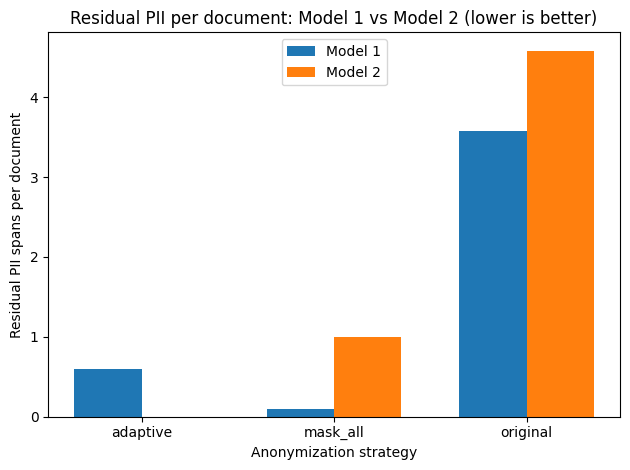

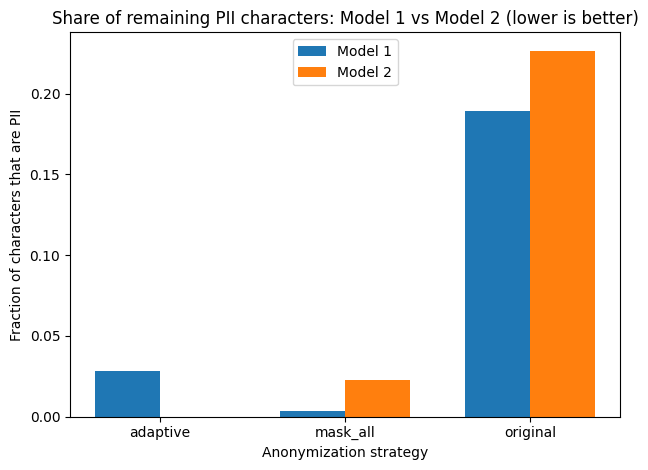

In [ ]:
# Build dicts: strategy to metric for each model
m1_spans_per_doc = {r["strategy"]: r["spans_per_doc"]   for r in privacy_results}
m1_frac_chars_pii = {r["strategy"]: r["frac_chars_pii"]  for r in privacy_results}

m2_spans_per_doc = {r["strategy"]: r["spans_per_doc"]   for r in privacy_results_1}
m2_frac_chars_pii = {r["strategy"]: r["frac_chars_pii"]  for r in privacy_results_1}

# Use the UNION of strategies to keep 'adaptive' even if only model1 has it
all_strats = sorted(set(m1_spans_per_doc.keys()) | set(m2_spans_per_doc.keys()))
print("All strategies across models:", all_strats)
def get_val(d, key):
    return d[key] if key in d else np.nan

vals_m1_spans = [get_val(m1_spans_per_doc, s)  for s in all_strats]
vals_m2_spans = [get_val(m2_spans_per_doc, s)  for s in all_strats]

vals_m1_frac = [get_val(m1_frac_chars_pii, s) for s in all_strats]
vals_m2_frac = [get_val(m2_frac_chars_pii, s) for s in all_strats]

x = np.arange(len(all_strats))
width = 0.35
# Plot 1: residual spans per document
plt.figure()
plt.bar(x - width/2, vals_m1_spans, width, label="Model 1")
plt.bar(x + width/2, vals_m2_spans, width, label="Model 2")

plt.xticks(x, all_strats)
plt.xlabel("Anonymization strategy")
plt.ylabel("Residual PII spans per document")
plt.title("Residual PII per document: Model 1 vs Model 2 (lower is better)")
plt.tight_layout()
plt.legend()
plt.show()

# Plot 2: fraction of characters that are PII
plt.figure()
plt.bar(x - width/2, vals_m1_frac, width, label="Model 1")
plt.bar(x + width/2, vals_m2_frac, width, label="Model 2")

plt.xticks(x, all_strats)
plt.xlabel("Anonymization strategy")
plt.ylabel("Fraction of characters that are PII")
plt.title("Share of remaining PII characters: Model 1 vs Model 2 (lower is better)")
plt.tight_layout()
plt.legend()
plt.show()



## Analyzing Which PII Types Remain

Let's dig deeper into the adaptive strategy to see which types of PII are still being detected after sanitization. This helps us understand where our approach might need improvement.

## Measuring Coverage of Ground Truth PII

The previous analysis checked what PII is still detectable after sanitization. Now we'll do the opposite - check how well we're removing the PII that we know is actually there (the ground truth labels from the dataset).

This function compares the original text to the sanitized version and counts how many of the labeled PII entities were successfully removed or changed. If the original PII text no longer appears in the sanitized version, we count it as successfully covered.

This gives us a different perspective - instead of asking "what leaked through?", we're asking "did we handle all the known PII?"

In [ ]:
SPAN_COL = "privacy_mask"  # The dataset column with ground truth PII labels
def coverage_stats_for_strategy(dataset, strategy: str, max_docs: int = 1000):
    """
    Check how well we're removing the PII that's actually labeled in the dataset.

    For each ground truth PII span, we check if the original text still appears
    after sanitization. If it's gone, we count it as successfully masked.

    This measures coverage: what percentage of known PII did we handle?
    """
    total_true_spans = 0
    masked_true_spans = 0

    true_by_label = Counter()
    masked_by_label = Counter()

    for i, ex in enumerate(dataset):
        if i >= max_docs:
            break

        text = ex[TEXT_COL]
        gt_spans = ex[SPAN_COL]  # Ground truth PII labels

        # Apply sanitization
        if strategy == "original":
            sanitized_text = text
        else:
            sanitized_text, _ = sanitize(text, strategy=strategy)

        # Check each ground truth PII
        for sp in gt_spans:
            start = int(sp["start"])
            end = int(sp["end"])
            label = sp["label"]

            # Validate the span
            if start < 0 or end > len(text) or end <= start:
                continue

            span_text = text[start:end]
            if not span_text.strip():
                continue  # Skip empty spans

            total_true_spans += 1
            true_by_label[label] += 1

            # Check if the original text is no longer present
            if span_text not in sanitized_text:
                masked_true_spans += 1
                masked_by_label[label] += 1

    if total_true_spans == 0:
        raise ValueError("No valid ground-truth spans found; check dataset or max_docs.")

    # Calculate overall coverage
    overall_coverage = masked_true_spans / total_true_spans

    # Calculate per-label coverage
    coverage_per_label = {}
    for label, total in true_by_label.items():
        cov = masked_by_label[label] / total if total > 0 else 0.0
        coverage_per_label[label] = cov

    return {
        "strategy": strategy,
        "n_docs": min(max_docs, len(dataset)),
        "total_true_spans": total_true_spans,
        "masked_true_spans": masked_true_spans,
        "overall_coverage": overall_coverage,
        "true_by_label": dict(true_by_label),
        "masked_by_label": dict(masked_by_label),
        "coverage_per_label": coverage_per_label,
    }

## Comparing Coverage Across Strategies

This helper function runs the coverage analysis on multiple strategies so we can compare how well each one handles the ground truth PII.

In [ ]:
def compare_coverage(dataset, strategies=None, max_docs: int = 1000):
    """
    Run coverage analysis for multiple strategies and collect results.
    Shows how well each approach removes ground truth PII.
    """
    if strategies is None:
        strategies = ["original", "mask_all", "adaptive"]

    results = []
    for strat in strategies:
        print(f"Computing GT coverage for strategy='{strat}' on {max_docs} docs...")
        stats = coverage_stats_for_strategy(dataset, strat, max_docs=max_docs)
        results.append(stats)
    return results

## Running the Coverage Evaluation

Let's run the coverage analysis to see what percentage of the actual labeled PII gets successfully removed or modified by each strategy. Higher percentages mean better protection of known PII.

Output is trunctuated but it shows pretty good results

In [ ]:
# Run coverage analysis on 1000 documents
set_active_model("model1")
coverage_results = compare_coverage(
    val_ds,
    strategies=["original", "mask_all", "adaptive"],
    max_docs=1000,
)

# Display the results with per-label breakdown
for r in coverage_results:
    print("\nStrategy:", r["strategy"])
    print(f"  Docs:               {r['n_docs']}")
    print(f"  Total GT PII spans: {r['total_true_spans']}")
    print(f"  Masked GT spans:    {r['masked_true_spans']}")
    print(f"  Overall coverage:   {100 * r['overall_coverage']:.2f}%")

    print("  Per-label coverage (fraction of GT spans masked):")
    for label, cov in sorted(r["coverage_per_label"].items(), key=lambda x: x[0]):
        print(f"    {label:20s} {100 * cov:6.2f}%")
set_active_model("model2")
coverage_results_1 = compare_coverage(
    val_ds,
    strategies=["original", "mask_all"],
    max_docs=1000,
)
# Display the results with per-label breakdown
for r in coverage_results_1:
    print("\nStrategy:", r["strategy"])
    print(f"  Docs:               {r['n_docs']}")
    print(f"  Total GT PII spans: {r['total_true_spans']}")
    print(f"  Masked GT spans:    {r['masked_true_spans']}")
    print(f"  Overall coverage:   {100 * r['overall_coverage']:.2f}%")

    print("  Per-label coverage (fraction of GT spans masked):")
    for label, cov in sorted(r["coverage_per_label"].items(), key=lambda x: x[0]):
        print(f"    {label:20s} {100 * cov:6.2f}%")

Computing GT coverage for strategy='original' on 1000 docs...
Computing GT coverage for strategy='mask_all' on 1000 docs...
Computing GT coverage for strategy='adaptive' on 1000 docs...

Strategy: original
  Docs:               1000
  Total GT PII spans: 3670
  Masked GT spans:    0
  Overall coverage:   0.00%
  Per-label coverage (fraction of GT spans masked):
    ACCOUNTNUM             0.00%
    BUILDINGNUM            0.00%
    CITY                   0.00%
    CREDITCARDNUMBER       0.00%
    DATEOFBIRTH            0.00%
    DRIVERLICENSENUM       0.00%
    EMAIL                  0.00%
    GIVENNAME              0.00%
    IDCARDNUM              0.00%
    PASSWORD               0.00%
    SOCIALNUM              0.00%
    STREET                 0.00%
    SURNAME                0.00%
    TAXNUM                 0.00%
    TELEPHONENUM           0.00%
    USERNAME               0.00%
    ZIPCODE                0.00%

Strategy: mask_all
  Docs:               1000
  Total GT PII spans: 3670
 

### How much labeled PII do we successfully remove?

Here we look at **coverage**: out of all PII spans that are labeled in the TAB dataset, what fraction do we actually remove?

The `compare_coverage` function tells us, for each strategy:

- **Overall coverage** = % of ground-truth PII spans that no longer appear in the sanitized text.
- **Per-label coverage** = coverage broken down by PII type (e.g., emails, phone numbers, locations).

The first plot shows overall coverage per strategy (higher is better).  
The second plot zooms in on the adaptive strategy and shows coverage per PII label, so we can see which types we handle best.


All strategies across models: ['adaptive', 'mask_all', 'original']


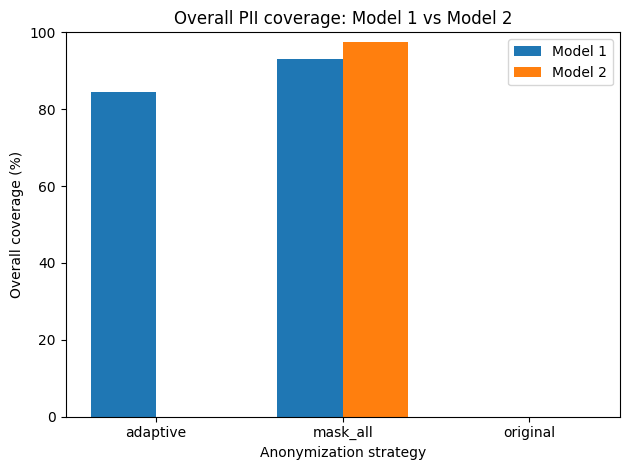


Per-label coverage for strategy 'mask_all'


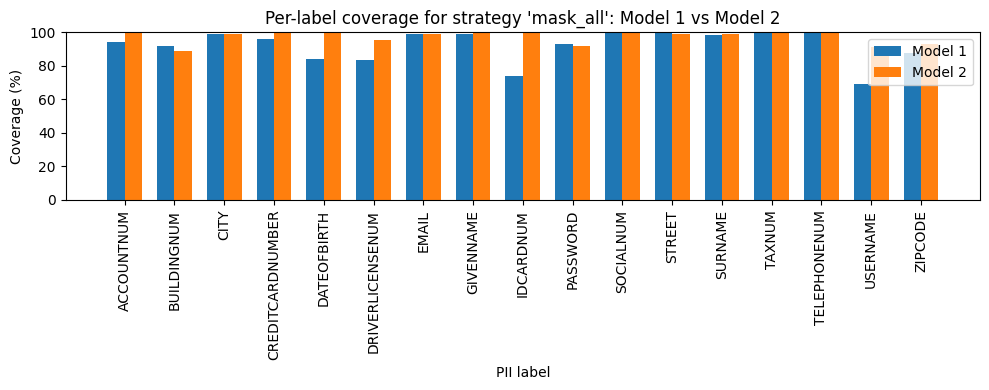


Per-label coverage for strategy 'adaptive'


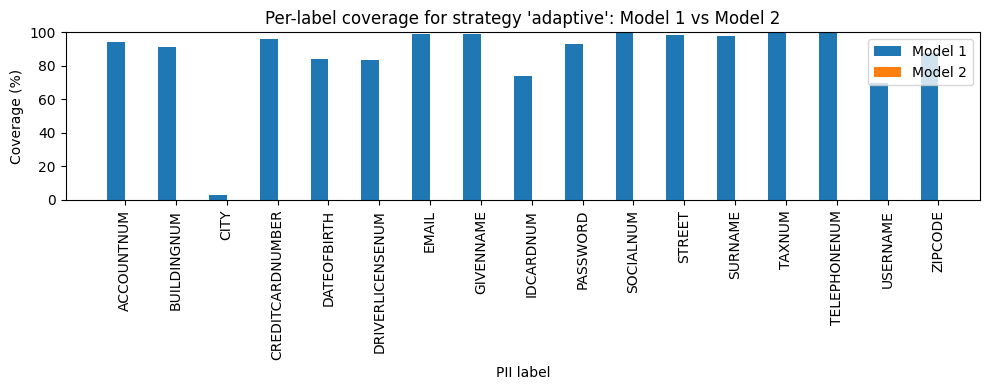

In [ ]:
# strategy of overall coverage for each model
cov_m1 = {r["strategy"]: 100.0 * r["overall_coverage"] for r in coverage_results}
cov_m2 = {r["strategy"]: 100.0 * r["overall_coverage"] for r in coverage_results_1}
all_strats = sorted(set(cov_m1.keys()) | set(cov_m2.keys()))
print("All strategies across models:", all_strats)
def get_or_nan(d, key):
    return d[key] if key in d else np.nan

vals_m1 = [get_or_nan(cov_m1, s) for s in all_strats]
vals_m2 = [get_or_nan(cov_m2, s) for s in all_strats]
x = np.arange(len(all_strats))
width = 0.35
plt.figure()
plt.bar(x - width/2, vals_m1, width, label="Model 1")
plt.bar(x + width/2, vals_m2, width, label="Model 2")
plt.xticks(x, all_strats)
plt.xlabel("Anonymization strategy")
plt.ylabel("Overall coverage (%)")
plt.title("Overall PII coverage: Model 1 vs Model 2")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()
# strategy to per-label coverage dict for each model
per_label_m1 = {r["strategy"]: r["coverage_per_label"] for r in coverage_results}
per_label_m2 = {r["strategy"]: r["coverage_per_label"] for r in coverage_results_1}
strategies_to_compare = ["mask_all", "adaptive"]
for strategy_to_compare in strategies_to_compare:
    if strategy_to_compare not in per_label_m1:
        print(f"\nStrategy '{strategy_to_compare}' not present in Model 1; skipping.")
        continue

    print(f"\nPer-label coverage for strategy '{strategy_to_compare}'")
    cov_labels_m1 = per_label_m1[strategy_to_compare]
    cov_labels_m2 = per_label_m2.get(strategy_to_compare, {})
    # Union of labels across both models for this strategy
    all_labels = sorted(set(cov_labels_m1.keys()) | set(cov_labels_m2.keys()))
    vals_m1 = [100.0 * cov_labels_m1.get(lbl, 0.0) for lbl in all_labels]
    vals_m2 = [100.0 * cov_labels_m2.get(lbl, np.nan) for lbl in all_labels]
    x = np.arange(len(all_labels))
    width = 0.35
    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, vals_m1, width, label="Model 1")
    plt.bar(x + width/2, vals_m2, width, label="Model 2")
    plt.xticks(x, all_labels, rotation=90)
    plt.xlabel("PII label")
    plt.ylabel("Coverage (%)")
    plt.title(f"Per-label coverage for strategy '{strategy_to_compare}': Model 1 vs Model 2")
    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Gradio UI

In [ ]:
# Gradio UI
# IMPORTANT: After the kernel restarts (session restart/timeout),
# you must run the original cells that define used functions
# I would recommend running all cells up until the cell starting with:
# "Running the Privacy Evaluation" (This cell isn't needed and takes a long time to execute)
# Once the required cells are run then you can run this cell to open the UI.
# It will open the UI in Google Colab and provide a link to a standalone webpage

import gradio as gr

# Sanitize the text
def run_sanitizer(input_mode, manual_text, uploaded_file, strategy):
    # Determine which input to use
    if input_mode == "Manual Text":
        text = manual_text or ""
    else:
        text = load_file(uploaded_file)

    if not text.strip():
        return "", ""

    sanitized_text, spans = sanitize(text, strategy=strategy)

    # Build a summary of detected PII
    summary_counter = {}
    for sp in spans:
        summary_counter[sp["label"]] = summary_counter.get(sp["label"], 0) + 1

    summary_lines = [f"{label}: {count}" for label, count in summary_counter.items()]
    summary_text = "\n".join(summary_lines) if summary_lines else "No PII detected."

    return sanitized_text, summary_text

# Load file upload
def load_file(file):
    if file is None:
        return ""
    try:
        return file.decode("utf-8")
    except Exception as e:
        return f"Error: Unable to read file. {str(e)}"

# Sanitize button is disabled unless there is text/file input
def toggle_sanitize_button(input_mode, manual_text, uploaded_file):
    has_text = bool(manual_text and manual_text.strip())
    has_file = uploaded_file is not None
    if (input_mode == "Manual Text" and has_text) or (input_mode == "File Upload" and has_file):
        return gr.update(interactive=True, elem_classes="sanitize-btn-enabled")
    else:
        return gr.update(interactive=False, elem_classes="sanitize-btn-disabled")

# Change text input type between manual and file upload
def toggle_inputs(choice):
    return (gr.update(visible=(choice=="Manual Text")),
            gr.update(visible=(choice=="File Upload")))

# UI Layout
with gr.Blocks() as demo:

    gr.Markdown(
        """
        # Text Anonymization Demo
        ### Enter text manually or upload a file. Select a sanitization mode and click **Sanitize**.
        """
    )

    gr.HTML(
        """
        <style>
        .sanitize-btn-enabled {
            background-color: #f97316 !important;
            color: white !important;
            transition: background-color 0.2s;
        }
        .sanitize-btn-enabled:hover {
            background-color: #ea580c !important;
        }
        .sanitize-btn-disabled {
            background-color: #d1d5db !important;
            color: #6b7280 !important;
        }
        </style>
        """
    )

    input_mode = gr.Radio(
        ["Manual Text", "File Upload"],
        value="Manual Text",
        label="Choose Input Method"
    )

    with gr.Row():
        with gr.Column(scale=1):
            manual_input = gr.Textbox(
                label="Manual Text Entry",
                placeholder="Type or paste text here…",
                lines=10,
                visible=True
            )

            file_input = gr.File(
                label="File Upload (.txt only)",
                file_types=[".txt"],
                type="binary",
                visible=False
            )

            mode_choice = gr.Radio(
                ["adaptive", "mask_all"],
                label="Sanitization Mode",
                value="adaptive"
            )

            sanitize_button = gr.Button(
                "Sanitize",
                interactive=False,
                elem_classes="sanitize-btn-disabled"
            )

        with gr.Column(scale=1):
            output_box = gr.Textbox(
                label="Sanitized Output",
                placeholder="Sanitized text will appear here",
                lines=15,
                interactive=False
            )

            summary_box = gr.Textbox(
                label="Redaction Summary",
                placeholder="Counts of detected PII will appear here",
                lines=8,
                interactive=False
            )

    # UI Events
    input_mode.change(toggle_inputs, inputs=input_mode, outputs=[manual_input, file_input])

    input_mode.change(toggle_sanitize_button, inputs=[input_mode, manual_input, file_input], outputs=[sanitize_button])
    manual_input.change(toggle_sanitize_button, inputs=[input_mode, manual_input, file_input], outputs=[sanitize_button])
    file_input.change(toggle_sanitize_button, inputs=[input_mode, manual_input, file_input], outputs=[sanitize_button])

    sanitize_button.click(
        fn=run_sanitizer,
        inputs=[input_mode, manual_input, file_input, mode_choice],
        outputs=[output_box, summary_box]
    )

    # Footer with Author/Class info
    gr.Markdown(
        """
        <div style="display: flex; justify-content: space-between; align-items: center; font-size: 0.9em; margin-top: 20px;">
            <span>UCDenver - CSCI5930 - Fall 2025</span>
            <span>Authors: Chase Perez, Garrett Rybarczyk and Kevin Schmitz</span>
        </div>
        """,
        elem_classes="text-gray-500"
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16800ca64092dd1fbe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Running the model against the Text Anonymization Benchmark

The Text Anonymization Benchmark is an open-source annotated corpus that includes benchmarks for measuring the performance of text anonymization methods in terms of privacy protection and utility preservation.

Most evaluations rely on recall and precision, recall measuring how well the document has been anonymized and the precision measuring how usable the document is.
Tab aims to improve evaluation metrics by:
1.   Weighing identifiers, direct identifiers like a name are weighted more highly.
2.   Checking the whole document to ensure that an identifier is masked correctly throughout the whole document, if one instance of it is missed, all other instances can be easily identified again.
3.   For utility measurement it takes into account the Information Content(IC) of the token that is being masked. If a token has high IC it is weighted more when calculating precision and recall. Something to note here is that TAB is only calculating the IC of the pre-anonymized token and doesn't take into account the IC of a replacement word. For doing that sort of evaluation we will use a Text Preserved Similarity measure later on from "Truthful text sanitization guided by inference attacks".



## Adding TAB helper functions

Before we can run our model against the TAB evaluation we need to add some helper functions so we can format our ouput like TAB is expecting.

In [ ]:
def detect_pii_and_TAB_format(text: str, doc_id: str, running_doc_list: Dict[str, List[List[int]]],conf_threshold: float = 0.0):
    """
    Simple interface for detecting PII in text.
    Returns a list with label, position, actual text, and confidence score for each PII found.
    """
    startEndList = []
    spans = predict_spans(
        text=text,
        model=model,
        tokenizer=tokenizer,
        id2label=id2label,
        max_length=256,
        device=None,  # Automatically picks GPU if available, otherwise CPU
        conf_threshold=conf_threshold,
    )

    # Extract the actual text for each detected span
    for sp in spans:
        sp["text"] = text[sp["start"]:sp["end"]]
        startEndList.append([sp["start"], sp["end"]])
    running_doc_list[doc_id] = startEndList
    return startEndList

def sanitize_for_TAB(text: str, doc_id: str, running_doc_list, strategy: str = "adaptive"):
    """
    Clean PII from text using the chosen strategy.
    Returns the sanitized text and a list of what was found (for debugging) and
    adds to the dictionary of replaced spans
    """
    # Find all the PII in the text
    spans = detect_pii(text)
    if not spans:
        return text, []

    # Process spans in order from start to end
    spans = sorted(spans, key=lambda s: s["start"])

    # Track pseudonyms for this document
    pseudo_state = {}

    # Build the cleaned text piece by piece
    sanitized_parts = []
    cursor = 0  # Where we are in the original text
    running_doc_list[doc_id] = []

    for span in spans:
        start = span["start"]
        end = span["end"]
        label = span["label"]
        span_text = text[start:end]

        # Add any text before this PII (unchanged)
        if start > cursor:
            sanitized_parts.append(text[cursor:start])

        # Decide how to replace this PII
        if strategy == "mask_all":
            # Simple approach - everything becomes a generic label
            replacement = f"[{label}]"

        elif strategy == "adaptive":
            # Smart approach - different methods for different types
            if label in HARD_IDS:
                # High-risk stuff gets fully masked
                replacement = f"[{label}]"
            elif label in CONTACT:
                # Contact info gets a consistent fake version
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in NAME_LIKE:
                # Names get pseudonymized to track relationships
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in QUASI_IDS:
                # Indirect identifiers get generalized
                replacement = generalize_span(label, span_text)
            else:
                # Unknown type - be safe and mask it
                replacement = f"[{label}]"
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        sanitized_parts.append(replacement)
        list_to_add = [start, end]
        running_doc_list[doc_id].append(list_to_add)
        cursor = end

    # Add any remaining text after the last PII
    if cursor < len(text):
        sanitized_parts.append(text[cursor:])

    # Combine everything into the final result
    sanitized_text = "".join(sanitized_parts)
    return sanitized_text, spans, running_doc_list

## Install TAB and TAB dependencies

Next we install TABs dependencies and TAB itself.

In [ ]:
!git clone https://github.com/NorskRegnesentral/text-anonymization-benchmark.git
!pip install intervaltree
!pip install spacy
!python -m spacy download en_core_web_md

import sys
sys.path.append('text-anonymization-benchmark') # Use the absolute path
import evaluation
from evaluation import MaskedDocument, GoldCorpus, evaluate

Cloning into 'text-anonymization-benchmark'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 90 (delta 26), reused 27 (delta 26), pack-reused 57 (from 1)
Receiving objects: 100% (90/90), 7.18 MiB | 2.05 MiB/s, done.
Resolving deltas: 100% (45/45), done.
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=bf10414bcad4269bc8cd943cae28251e61f55377e913ec101f10176f3ba72a27
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built intervaltree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 23.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to

/content/text-anonymization-benchmark/evaluation.py:284: SyntaxWarning: invalid escape sequence '\s'
  context = re.sub("\s\s+", " ", context.replace("\n", " "), re.DOTALL)
/content/text-anonymization-benchmark/evaluation.py:511: SyntaxWarning: invalid escape sequence '\w'
  for match in re.finditer("\w+", self.text[start:end]):


## Import TAB test dataset

In [ ]:
from datasets import load_dataset

tab = load_dataset("ildpil/text-anonymization-benchmark")  # train/dev/test splits
test_docs = tab["test"]
gold_corpus = GoldCorpus(R"text-anonymization-benchmark/echr_test.json")

README.md: 0.00B [00:00, ?B/s]

echr_train.zip:   0%|          | 0.00/5.31M [00:00<?, ?B/s]

echr_dev.zip:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

echr_test.zip:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1112 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/541 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/555 [00:00<?, ? examples/s]

Reading annotated corpus with 127 documents


## Create TAB formatted output

First we create lists of data for TAB, one using the adaptive masking and the other using full masking. Then we take those and populate the MaskedDocument class with that data

In [ ]:
set_active_model('model1')
final_doc_list_adaptive = {}
for doc in test_docs:
    sanitize_for_TAB(doc["text"], doc["doc_id"], final_doc_list_adaptive)

masked_docs_adaptive = []
for doc_id, masked_spans in final_doc_list_adaptive.items():
    doc = MaskedDocument(doc_id, [])
    if type(masked_spans)!=list:
        raise RuntimeError("Masked spans for the document must be a list of (start, end) tuples")

    for start, end in masked_spans:
        doc.masked_spans.append((start, end))
    masked_docs_adaptive.append(doc)
set_active_model("model2")
final_doc_list_adaptive_1 = {}
for doc in test_docs:
    sanitize_for_TAB(doc["text"], doc["doc_id"], final_doc_list_adaptive_1)

masked_docs_adaptive_1 = []
for doc_id, masked_spans in final_doc_list_adaptive_1.items():
    doc = MaskedDocument(doc_id, [])
    if type(masked_spans)!=list:
        raise RuntimeError("Masked spans for the document must be a list of (start, end) tuples")

    for start, end in masked_spans:
        doc.masked_spans.append((start, end))
    masked_docs_adaptive_1.append(doc)

## Run evaluation

Finally we can run the evaluation.

In [ ]:
measures_adaptive = evaluate(gold_corpus, masked_docs_adaptive, True)
measures_adaptive_1 = evaluate(gold_corpus, masked_docs_adaptive_1, True)

Computing evaluation metrics for 123 documents


100%|██████████| 123/123 [00:00<00:00, 1667.52it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 123/123 [00:11<00:00, 10.32it/s]


Computing evaluation metrics for 127 documents


100%|██████████| 127/127 [00:00<00:00, 3897.45it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 127/127 [00:10<00:00, 11.78it/s]


In [ ]:
print("==> Token-level recall on all identifiers: %.3f"%measures_adaptive["token_recall"])
print("==> Token-level recall on all identifiers, factored by type:")
for ent_type, token_recall_for_ent_type in measures_adaptive["token_recall_by_type"].items():
    print("\t%s:%.3f"%(ent_type, token_recall_for_ent_type))
print("==> Mention-level recall on all identifiers: %.3f"%measures_adaptive["mention_recall"])
print("==> Entity-level recall on direct identifiers: %.3f"%measures_adaptive["recall_direct_entities"])
print("==> Entity-level recall on quasi identifiers: %.3f"%measures_adaptive["recall_quasi_entities"])
print("==> Uniform token-level precision on all identifiers: %.3f"%measures_adaptive["token_precision"])
print("==> Uniform mention-level precision on all identifiers: %.3f"%measures_adaptive["mention_precision"])

print("==> Weighted, token-level precision on all identifiers: %.3f"%measures_adaptive["weighted_token_precision"])
print("==> Weighted, mention-level precision on all identifiers: %.3f"%measures_adaptive["weighted_mention_precision"])

print("==> Token-level recall on all identifiers: %.3f"%measures_adaptive_1["token_recall"])
print("==> Token-level recall on all identifiers, factored by type:")
for ent_type, token_recall_for_ent_type in measures_adaptive_1["token_recall_by_type"].items():
    print("\t%s:%.3f"%(ent_type, token_recall_for_ent_type))
print("==> Mention-level recall on all identifiers: %.3f"%measures_adaptive_1["mention_recall"])
print("==> Entity-level recall on direct identifiers: %.3f"%measures_adaptive_1["recall_direct_entities"])
print("==> Entity-level recall on quasi identifiers: %.3f"%measures_adaptive_1["recall_quasi_entities"])
print("==> Uniform token-level precision on all identifiers: %.3f"%measures_adaptive_1["token_precision"])
print("==> Uniform mention-level precision on all identifiers: %.3f"%measures_adaptive_1["mention_precision"])

print("==> Weighted, token-level precision on all identifiers: %.3f"%measures_adaptive_1["weighted_token_precision"])
print("==> Weighted, mention-level precision on all identifiers: %.3f"%measures_adaptive_1["weighted_mention_precision"])

==> Token-level recall on all identifiers: 0.135
==> Token-level recall on all identifiers, factored by type:
	CODE:0.005
	PERSON:0.429
	DATETIME:0.029
	ORG:0.102
	LOC:0.283
	DEM:0.090
	MISC:0.167
	QUANTITY:0.024
==> Mention-level recall on all identifiers: 0.058
==> Entity-level recall on direct identifiers: 0.237
==> Entity-level recall on quasi identifiers: 0.046
==> Uniform token-level precision on all identifiers: 0.936
==> Uniform mention-level precision on all identifiers: 0.934
==> Weighted, token-level precision on all identifiers: 0.943
==> Weighted, mention-level precision on all identifiers: 0.940
==> Token-level recall on all identifiers: 0.273
==> Token-level recall on all identifiers, factored by type:
	CODE:0.440
	PERSON:0.577
	DATETIME:0.185
	ORG:0.151
	LOC:0.266
	DEM:0.098
	MISC:0.187
	QUANTITY:0.027
==> Mention-level recall on all identifiers: 0.207
==> Entity-level recall on direct identifiers: 0.863
==> Entity-level recall on quasi identifiers: 0.184
==> Uniform to

## Semantic Similarity evaluation

One major drawback of the TAB evaluation is that it only takes into account the Information Content of the text span being masked. We can get a better idea of the preserved utility of the text if we also look at the information content of the text span that we are using as a replacement, which the adaptive masking that we have attempts to do.

For this approach we use the framework provided by "Truthful text sanitization guided by inference attacks" which also utilizes TAB but enhances the evaluation to take into account the replacement text spans IC.

In [ ]:
!git clone https://github.com/IldikoPilan/text_sanitization.git

import sys
sys.path.append('text_sanitization') # Use the absolute path
from eval_TPS import MaskedDocument as MaskedDocTPS, GoldCorpus as GoldCorpusTPS, BertTokenWeighting

Cloning into 'text_sanitization'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 24), reused 14 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 29.55 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Adding TPS helper functions

Similar to TAB we will add a helper function to format the data how we want it.

In [ ]:
def sanitize_for_TPS(text: str, doc_id: str, running_doc_list, strategy: str = "adaptive"):
    """
    Clean PII from text using the chosen strategy.
    Returns the sanitized text and a list of what was found (for debugging) and
    adds to the dictionary of replaced spans
    """
    # Find all the PII in the text
    spans = detect_pii(text)
    if not spans:
        return text, []

    # Process spans in order from start to end
    spans = sorted(spans, key=lambda s: s["start"])

    # Track pseudonyms for this document
    pseudo_state = {}

    # Build the cleaned text piece by piece
    sanitized_parts = []
    cursor = 0  # Where we are in the original text
    running_doc_list[doc_id] = []

    for span in spans:
        start = span["start"]
        end = span["end"]
        label = span["label"]
        span_text = text[start:end]

        # Add any text before this PII (unchanged)
        if start > cursor:
            sanitized_parts.append(text[cursor:start])

        # Decide how to replace this PII
        if strategy == "mask_all":
            # Simple approach - everything becomes a generic label
            replacement = f"[{label}]"

        elif strategy == "adaptive":
            # Smart approach - different methods for different types
            if label in HARD_IDS:
                # High-risk stuff gets fully masked
                replacement = f"[{label}]"
            elif label in CONTACT:
                # Contact info gets a consistent fake version
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in NAME_LIKE:
                # Names get pseudonymized to track relationships
                replacement = get_pseudonym(label, span_text, pseudo_state)
            elif label in QUASI_IDS:
                # Indirect identifiers get generalized
                replacement = generalize_span(label, span_text)
            else:
                # Unknown type - be safe and mask it
                replacement = f"[{label}]"
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        sanitized_parts.append(replacement)
        list_to_add = [start, end, replacement]
        running_doc_list[doc_id].append(list_to_add)
        cursor = end

    # Add any remaining text after the last PII
    if cursor < len(text):
        sanitized_parts.append(text[cursor:])

    # Combine everything into the final result
    sanitized_text = "".join(sanitized_parts)
    return sanitized_text, spans, running_doc_list

In [ ]:
final_doc_list_adaptive_replacement = {}
for doc in test_docs:
    sanitize_for_TPS(doc["text"], doc["doc_id"], final_doc_list_adaptive_replacement)
print(final_doc_list_adaptive_replacement)

final_doc_list_masked_replacement = {}
for doc in test_docs:
    sanitize_for_TPS(doc["text"], doc["doc_id"], final_doc_list_masked_replacement, strategy="mask_all")
print(final_doc_list_masked_replacement)

masked_docs_adaptive_TPS = []
for doc_id, masked_spans in final_doc_list_adaptive_replacement.items():
    doc = MaskedDocTPS(doc_id, [], [])
    if type(masked_spans)!=list:
        raise RuntimeError("Masked spans for the document must be a list of (start, end) tuples")

    for start, end, replacement in masked_spans:
        doc.masked_spans.append((start, end))
        doc.replacements.append(replacement)
    masked_docs_adaptive_TPS.append(doc)

masked_docs_masked_TPS = []
for doc_id, masked_spans in final_doc_list_masked_replacement.items():
    doc = MaskedDocTPS(doc_id, [], [])
    if type(masked_spans)!=list:
        raise RuntimeError("Masked spans for the document must be a list of (start, end) tuples")

    for start, end, replacement in masked_spans:
        doc.masked_spans.append((start, end))
        doc.replacements.append(replacement)
    masked_docs_masked_TPS.append(doc)


{'001-61807': [[317, 322, 'Person_1'], [323, 329, 'Person_2'], [334, 342, 'Person_3'], [343, 350, 'Person_4'], [355, 360, 'Person_5'], [361, 369, 'Person_6'], [377, 382, 'Person_7'], [383, 388, 'Person_8'], [502, 508, 'Ankara'], [711, 715, '[ZIPCODE]'], [734, 738, '[ZIPCODE]']], '001-61253': [[705, 712, 'Florida']], '001-66929': [[312, 318, 'Person_1'], [319, 325, 'Person_2'], [326, 332, 'Person_3'], [340, 345, 'Person_4'], [346, 352, 'Person_3'], [466, 473, 'Person_5'], [498, 503, 'Izmir'], [936, 940, '[ZIPCODE]'], [945, 949, '[ZIPCODE]']], '001-159913': [[255, 260, 'Person_1'], [261, 265, 'Person_2'], [378, 384, 'Person_3'], [409, 415, 'Lublin'], [497, 508, 'Person_4'], [847, 851, '[ZIPCODE]'], [871, 877, 'Lublin']], '001-61227': [[298, 305, 'Person_1'], [312, 319, 'Person_2'], [432, 439, 'Person_3'], [464, 471, 'Glasgow']], '001-90749': [[313, 320, 'Person_1'], [321, 331, 'Person_2'], [407, 415, 'Person_3'], [440, 447, 'Nicosia']], '001-79346': [[256, 260, 'Person_1'], [261, 269, 'P

In [ ]:
gold_corpus_tps = GoldCorpusTPS(R"text-anonymization-benchmark/echr_test.json")

Reading annotated corpus with 127 documents


  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
# Weighting scheme
weighting_scheme = BertTokenWeighting()

# Metrics settings
sim_model_name = "paraphrase-albert-base-v2"
word_alterning = 6

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Running the semantic similarity evaluation

In [ ]:
# Compute TPS
print("Computing evaluation metrics for (%i documents)"%len(masked_docs_adaptive_TPS))
tps_adaptive, tps_array_adaptive, all_similarities_adaptive = gold_corpus_tps.get_TPS(masked_docs_adaptive_TPS, weighting_scheme, word_alterning=word_alterning, sim_model_name=sim_model_name)
tps_std_adaptive = tps_array_adaptive.std()
mean_sim_adaptive = all_similarities_adaptive.mean()

# Print results
print(f"==> Adaptive test TPS: {tps_adaptive:3f}±{tps_std_adaptive:3f} | Mean similarity:{mean_sim_adaptive:.3f}")

Computing evaluation metrics for (123 documents)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors


==> Adaptive test TPS: 0.988157±0.009891 | Mean similarity:0.418


In [ ]:
print("Computing evaluation metrics for (%i documents)"%len(masked_docs_masked_TPS))
tps_masked, tps_array_masked, all_similarities_masked = gold_corpus_tps.get_TPS(masked_docs_masked_TPS, weighting_scheme, word_alterning=word_alterning, sim_model_name=sim_model_name)
tps_std_masked = tps_array_masked.std()
mean_sim_masked = all_similarities_masked.mean()

# Print results
print(f"==> Masked test TPS: {tps_masked:3f}±{tps_std_masked:3f} | Mean similarity:{mean_sim_masked:.3f}")

Computing evaluation metrics for (123 documents)


  0%|          | 0/123 [00:00<?, ?it/s]

==> Masked test TPS: 0.983393±0.012771 | Mean similarity:0.217


### Textual Privacy Score (TPS) and semantic similarity

TPS is a metric designed for anonymization that combines:

- **Privacy** - penalizing texts where PII is not properly hidden.
- **Utility** - rewarding texts that stay semantically similar to the original.

Here we compare the TPS and average sentence-similarity score for:

- The **mask-all** strategy (everything becomes a placeholder).
- The **adaptive** strategy (more selective masking and pseudonymization).

Higher TPS and higher similarity mean a better privacy-utility balance: we have strong privacy while still preserving the original meaning as much as possible.


In [ ]:
def build_tps_docs_for_current_model():
    """
    Build MaskedDocTPS lists for:
      - adaptive strategy
      - mask_all strategy
    using the CURRENT active PII model (via sanitize_for_TPS -> detect_pii).

    Returns:
      masked_docs_adaptive_TPS, masked_docs_masked_TPS
    """
    # Collect [start, end, replacement] for each doc
    final_doc_list_adaptive_replacement = {}
    final_doc_list_masked_replacement   = {}

    # Adaptive strategy
    for doc in test_docs:
        sanitize_for_TPS(doc["text"], doc["doc_id"], final_doc_list_adaptive_replacement, strategy="adaptive")

    # Mask-all strategy
    for doc in test_docs:
        sanitize_for_TPS(doc["text"], doc["doc_id"], final_doc_list_masked_replacement, strategy="mask_all")

    # Convert to MaskedDocTPS objects: adaptive
    masked_docs_adaptive_TPS = []
    for doc_id, masked_spans in final_doc_list_adaptive_replacement.items():
        doc = MaskedDocTPS(doc_id, [], [])
        if not isinstance(masked_spans, list):
            raise RuntimeError("Masked spans for the document must be a list of (start, end, replacement) tuples")

        for start, end, replacement in masked_spans:
            doc.masked_spans.append((start, end))
            doc.replacements.append(replacement)
        masked_docs_adaptive_TPS.append(doc)

    # Convert to MaskedDocTPS objects: mask_all
    masked_docs_masked_TPS = []
    for doc_id, masked_spans in final_doc_list_masked_replacement.items():
        doc = MaskedDocTPS(doc_id, [], [])
        if not isinstance(masked_spans, list):
            raise RuntimeError("Masked spans for the document must be a list of (start, end, replacement) tuples")

        for start, end, replacement in masked_spans:
            doc.masked_spans.append((start, end))
            doc.replacements.append(replacement)
        masked_docs_masked_TPS.append(doc)

    return masked_docs_adaptive_TPS, masked_docs_masked_TPS


In [ ]:
import pandas as pd

tps_rows = []
for which, name in [("model1", "Model 1"), ("model2", "Model 2")]:
    print(f"\n=== TPS evaluation for {name} ===")
    set_active_model(which)  # updates global model/tokenizer/id2label used by sanitize_for_TPS
    # Build masked docs for THIS model
    masked_docs_adaptive_TPS, masked_docs_masked_TPS = build_tps_docs_for_current_model()
    # Compute TPS for adaptive
    print(f"Computing TPS for adaptive ({name}) on {len(masked_docs_adaptive_TPS)} documents")
    tps_adaptive, tps_array_adaptive, all_similarities_adaptive = gold_corpus_tps.get_TPS(
        masked_docs_adaptive_TPS,
        weighting_scheme,
        word_alterning=word_alterning,
        sim_model_name=sim_model_name,
    )
    tps_std_adaptive = tps_array_adaptive.std()
    mean_sim_adaptive = all_similarities_adaptive.mean()
    # Compute TPS for mask_all
    print(f"Computing TPS for mask_all ({name}) on {len(masked_docs_masked_TPS)} documents")
    tps_masked, tps_array_masked, all_similarities_masked = gold_corpus_tps.get_TPS(
        masked_docs_masked_TPS,
        weighting_scheme,
        word_alterning=word_alterning,
        sim_model_name=sim_model_name,
    )
    tps_std_masked = tps_array_masked.std()
    mean_sim_masked = all_similarities_masked.mean()
    # Store results in a table-friendly format
    tps_rows.append({
        "Model": name,
        "Strategy": "adaptive",
        "TPS_mean": tps_adaptive,
        "TPS_std": tps_std_adaptive,
        "Mean_similarity": mean_sim_adaptive,
    })
    tps_rows.append({
        "Model": name,
        "Strategy": "mask_all",
        "TPS_mean": tps_masked,
        "TPS_std": tps_std_masked,
        "Mean_similarity": mean_sim_masked,
    })
# Build one nice DataFrame with TPS metrics for *both* models and *both* strategies
tps_all_models = pd.DataFrame(tps_rows)
display(tps_all_models.style.format({
    "TPS_mean": "{:.3f}",
    "TPS_std": "{:.3f}",
    "Mean_similarity": "{:.3f}",
}))


=== TPS evaluation for Model 1 ===
Computing TPS for adaptive (Model 1) on 123 documents


  0%|          | 0/123 [00:00<?, ?it/s]

Computing TPS for mask_all (Model 1) on 123 documents


  0%|          | 0/123 [00:00<?, ?it/s]


=== TPS evaluation for Model 2 ===
Computing TPS for adaptive (Model 2) on 127 documents


  0%|          | 0/127 [00:00<?, ?it/s]

Computing TPS for mask_all (Model 2) on 127 documents


  0%|          | 0/127 [00:00<?, ?it/s]

,Model,Strategy,TPS_mean,TPS_std,Mean_similarity
0,Model 1,adaptive,0.988,0.010,0.418
1,Model 1,mask_all,0.983,0.013,0.217
2,Model 2,adaptive,0.965,0.022,0.255
3,Model 2,mask_all,0.965,0.022,0.255



TPS results (Markdown table):



# AG News classification accuracy
## Load AG news and prepare plain text + labels

In [ ]:
from datasets import load_dataset

#Load AG News
ag = load_dataset("ag_news")  # train: 120k, test: 7.6k
# Optional subsampling for speed
train_size = 10000
test_size = 2000

train_ds = ag["train"].shuffle(seed=42).select(range(train_size))
test_ds = ag["test"].shuffle(seed=42).select(range(test_size))

# Extract raw texts and labels
train_texts = [ex["text"] for ex in train_ds]
y_train = [ex["label"] for ex in train_ds]

test_texts = [ex["text"] for ex in test_ds]
y_test = [ex["label"] for ex in test_ds]
print(train_ds[0])


{'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.', 'label': 0}


## Helper to reconstruct anonymized text from spans
- This uses the lists stored in running_doc_list[doc_id] as [start, end, replacement]

In [ ]:
def apply_spans(text, spans):
    """
    Given the original text and a list of [start, end, replacement],
    return the anonymized text by inserting the replacements.
    """
    if not spans:
        return text  # nothing to mask
    # sort by start index
    spans_sorted = sorted(spans, key=lambda x: x[0])
    out = []
    prev = 0
    for start, end, repl in spans_sorted:
        out.append(text[prev:start])
        out.append(repl)
        prev = end
    out.append(text[prev:])
    return "".join(out)

## Build original adaptive mask-all version for a givien split
- This is where we use sanitize_for_tps. No roginial_texts floating around; we pass in the list explicitly

In [ ]:
def build_anonymized_versions(texts, split_name):
    """
    For a list of texts and a split name ("train"/"test"), return:
      - orig_texts
      - adaptive_texts
      - maskall_texts
    """
    # Run adaptive + mask-all anonymization and store spans
    final_adaptive = {}
    final_maskall  = {}
    for i, txt in enumerate(texts):
        doc_id = f"{split_name}-{i}"
        sanitize_for_TPS(txt, doc_id, final_adaptive, strategy="adaptive")
        sanitize_for_TPS(txt, doc_id, final_maskall,  strategy="mask_all")

    # Reconstruct anonymized texts
    adaptive_texts = []
    maskall_texts  = []
    for i, txt in enumerate(texts):
        doc_id = f"{split_name}-{i}"
        spans_adap = final_adaptive.get(doc_id, [])
        spans_mask = final_maskall.get(doc_id, [])

        adaptive_texts.append(apply_spans(txt, spans_adap))
        maskall_texts.append(apply_spans(txt, spans_mask))
    return texts, adaptive_texts, maskall_texts

In [ ]:
set_active_model("model1")
X_train_orig, X_train_adap, X_train_mask = build_anonymized_versions(train_texts, "train")
X_test_orig,  X_test_adap,  X_test_mask  = build_anonymized_versions(test_texts,  "test")

In [ ]:
set_active_model("model2")
X_train_orig1, X_train_adap1, X_train_mask1 = build_anonymized_versions(train_texts, "train")
X_test_orig1,  X_test_adap1,  X_test_mask1  = build_anonymized_versions(test_texts,  "test")

## Train and evaluate the classifier on each version

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def eval_version(X_train, X_test, y_train, y_test, label_name):
    """
    Train TF-IDF + Logistic Regression and report accuracy + F1.
    """
    vec = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)

    clf = LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        multi_class="auto"
    )
    clf.fit(Xtr, y_train)

    y_pred = clf.predict(Xte)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="weighted")

    print(f"{label_name:12s} | acc = {acc:.3f} | f1 = {f1:.3f}")
    return acc, f1

results = {}
results["original"] = eval_version(X_train_orig, X_test_orig, y_train, y_test, "Original")
results["mask_all"] = eval_version(X_train_mask, X_test_mask, y_train, y_test, "Mask-all")
results["adaptive"] = eval_version(X_train_adap, X_test_adap, y_train, y_test, "Adaptive")
results1 = {}
results1["original"] = eval_version(X_train_orig1, X_test_orig1, y_train, y_test, "Original")
results1["mask_all"] = eval_version(X_train_mask1, X_test_mask1, y_train, y_test, "Mask-all")
#print("\nSummary:", results, results1)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Original     | acc = 0.883 | f1 = 0.883


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mask-all     | acc = 0.872 | f1 = 0.871


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Adaptive     | acc = 0.875 | f1 = 0.875


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Original     | acc = 0.883 | f1 = 0.883


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mask-all     | acc = 0.861 | f1 = 0.860


### Downstream utility: AG News topic classification

To measure downstream utility, we train a simple TF-IDF + Logistic Regression classifier on the AG News dataset.

We compare three versions of the text:

- **Original**: no anonymization.
- **Mask-all**: all detected PII replaced with generic placeholders.
- **Adaptive**: more selective masking and pseudonymization.

By plotting accuracy and F1 score side by side, we can see how much anonymization hurts performance on a realistic classification task. The expectation is:

- Original text performs best.
- Mask-all has the lowest performance, because it removes the most information.
- Adaptive lands in between, preserving more of the signal while still protecting privacy.


In [ ]:
rows = []
# Model 1
for strat, (acc, f1) in results.items():
    rows.append({
        "Model": "Model 1",
        "Strategy": strat,
        "Accuracy": acc,
        "F1": f1,
    })
# Model 2
for strat, (acc, f1) in results1.items():
    rows.append({
        "Model": "Model 2",
        "Strategy": strat,
        "Accuracy": acc,
        "F1": f1,
    })

df_results = pd.DataFrame(rows)
pretty_names = {
    "original": "Original",
    "mask_all": "Mask-all",
    "adaptive": "Adaptive",
}
df_results["Strategy"] = df_results["Strategy"].map(pretty_names).fillna(df_results["Strategy"])

# Show as a nice notebook table
display(df_results.style.format({"Accuracy": "{:.3f}", "F1": "{:.3f}"}))

,Model,Strategy,Accuracy,F1
0,Model 1,Original,0.883,0.883
1,Model 1,Mask-all,0.872,0.871
2,Model 1,Adaptive,0.875,0.875
3,Model 2,Original,0.883,0.883
4,Model 2,Mask-all,0.861,0.860


### How to interpret the confusion matrices

Each confusion matrix below shows **how the AG News classifier behaves** under a given anonymization strategy (original, mask-all, adaptive).

- The **rows** correspond to the **true classes** (the real labels in the dataset).
- The **columns** correspond to the **predicted classes** (what the model predicted).
- The **value in row *i*, column *j*** is the number of test examples whose true class is *i* but were predicted as *j*.

Key things to look for:

- **Diagonal cells (top-left to bottom-right)**  
  - These are the **correct predictions**.  
  - A stronger diagonal (larger numbers / darker color on the diagonal) means better performance.
- **Off-diagonal cells**  
  - These are **misclassifications**.  
  - For example, if the “Business” row has big values under the “World” column, the model often confuses Business news with World news.
- **Comparing across strategies**  
  - If anonymization hurts performance, you will see:
    - Diagonal numbers get smaller.
    - Off-diagonal cells get larger (more confusion between classes).
  - By comparing the three matrices (Original vs Mask-all vs Adaptive), you can see **where** anonymization introduces extra confusion and whether adaptive anonymization preserves structure better than mask-all.


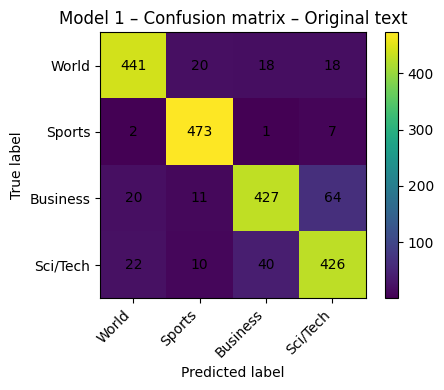

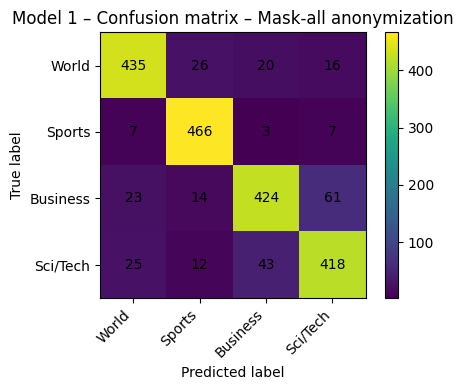

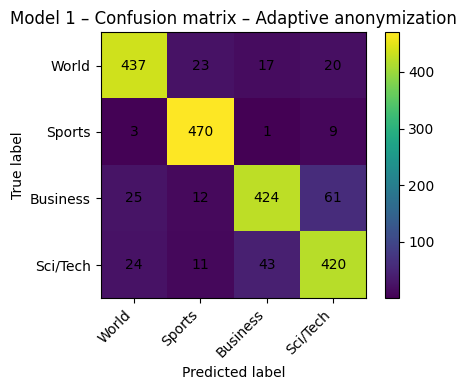

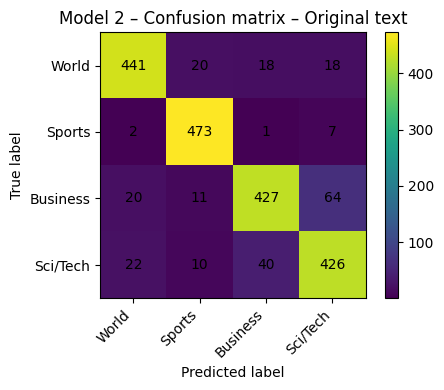

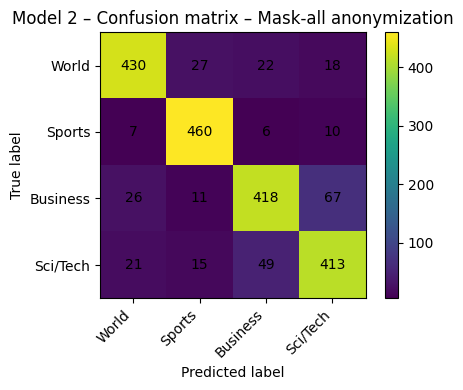

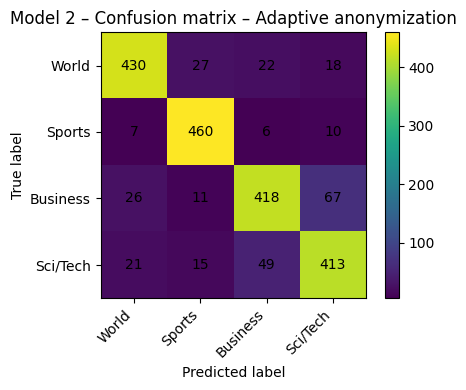

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

label_names = ag["train"].features["label"].names

def train_and_predict(X_train, X_test, y_train, y_test):
    vec = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)

    clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    clf.fit(Xtr, y_train)
    return clf.predict(Xte)

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha="right")
    plt.yticks(ticks, labels)

    # Annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()

#Model 1
y_pred_orig_m1 = train_and_predict(X_train_orig,  X_test_orig,  y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_orig_m1, label_names,
    title="Model 1 – Confusion matrix – Original text"
)

y_pred_mask_m1 = train_and_predict(X_train_mask,  X_test_mask,  y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_mask_m1, label_names,
    title="Model 1 – Confusion matrix – Mask-all anonymization"
)

y_pred_adap_m1 = train_and_predict(X_train_adap,  X_test_adap,  y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_adap_m1, label_names,
    title="Model 1 – Confusion matrix – Adaptive anonymization"
)

#Model 2
y_pred_orig_m2 = train_and_predict(X_train_orig1, X_test_orig1, y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_orig_m2, label_names,
    title="Model 2 – Confusion matrix – Original text"
)

y_pred_mask_m2 = train_and_predict(X_train_mask1, X_test_mask1, y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_mask_m2, label_names,
    title="Model 2 – Confusion matrix – Mask-all anonymization"
)

y_pred_adap_m2 = train_and_predict(X_train_adap1, X_test_adap1, y_train, y_test)
plot_confusion_matrix(
    y_test, y_pred_adap_m2, label_names,
    title="Model 2 – Confusion matrix – Adaptive anonymization")


### Putting it all together: privacy vs utility trade-off

Finally, we summarize the **privacy-utility trade-off** in a single plot.

For each strategy (original, mask-all, adaptive), we combine:

- A **privacy metric**: 1 - (fraction of characters that are still PII) on the TAB dataset.
- A **utility metric**: AG News classification accuracy.

Each point on the scatter plot represents one strategy:

- Original: high utility, low privacy.
- Mask-all: high privacy, lower utility.
- Adaptive: in between, ideally closer to the top-right (good privacy and good utility).

This makes it easy to see visually how our anonymization choices move us along the privacy-utility curve.


Strategies across models: ['adaptive', 'mask_all', 'original']


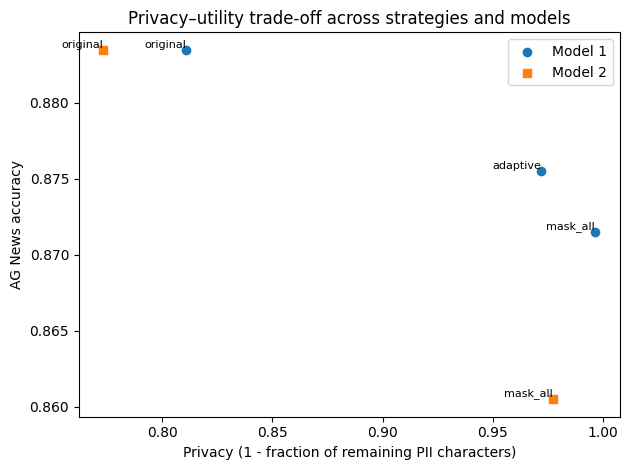

In [ ]:
# Model 1 privacy metrics
privacy_by_strategy_m1 = {r["strategy"]: r for r in privacy_results}
# Model 2 privacy metrics
privacy_by_strategy_m2 = {r["strategy"]: r for r in privacy_results_1}

# Model 1 utility (AG News accuracy)
utility_by_strategy_m1 = {s: results[s][0] for s in results}
# Model 2 utility
utility_by_strategy_m2 = {s: results1[s][0] for s in results1}
# Union of all strategies seen across both models
all_strats = sorted(
    set(privacy_by_strategy_m1.keys()) |
    set(privacy_by_strategy_m2.keys())
)
print("Strategies across models:", all_strats)
plt.figure()
# Helper that plots one model
def add_model_points(model_name, privacy_dict, utility_dict, marker):
    xs = []
    ys = []
    labels = []
    for s in all_strats:
        if s in privacy_dict and s in utility_dict:
            # Privacy: higher is better
            priv = 1.0 - privacy_dict[s]["frac_chars_pii"]
            # Utility: AG News accuracy
            util = utility_dict[s]
            xs.append(priv)
            ys.append(util)
            labels.append(s)
    plt.scatter(xs, ys, marker=marker, label=model_name)
    # Annotate each point with strategy name (original / mask_all / adaptive)
    for s, x, y in zip(labels, xs, ys):
        plt.text(x, y, s, fontsize=8, ha="right", va="bottom")
# Add points for both models
add_model_points("Model 1", privacy_by_strategy_m1, utility_by_strategy_m1, marker="o")
add_model_points("Model 2", privacy_by_strategy_m2, utility_by_strategy_m2, marker="s")
plt.xlabel("Privacy (1 - fraction of remaining PII characters)")
plt.ylabel("AG News accuracy")
plt.title("Privacy–utility trade-off across strategies and models")
plt.legend()
plt.tight_layout()
plt.show()

# Results

The model seems to struggle a little bit with the TAB data set getting some lower scores across the board on masking PII. Though we still have a very high precision meaning in general we are doing well at preserving the utility of the text.

For the semantic similarity we have very high scores of 98.8% similarity on the adaptive masking method and 98.3% similarity on the fully masking method. Though I think a big contributer to these high scores is the relatively low recall we have when working with this dataset, a lot of PII seems to be getting through creating a higher re-identification risk.

Summary of our anonymization approach and evaluation

We first trained a PII detection model on the ai4privacy dataset using a multilingual BERT token classification head. On the validation set, this detector achieved strong performance: about 0.91 F1, 0.91 precision, 0.91 recall, and 0.99 token-level accuracy (eval_f1 ~ 0.9105, eval_accuracy ~ 0.9891). These scores suggest that the model is reliable enough to serve as the core "PII finder" in our anonymization pipeline and also as a reasonable proxy for an automated adversary when we measure residual PII.

On top of this detector, we built an anonymization pipeline that can produce three versions of each document. The original version is untouched. The mask-all version replaces every detected PII span with a placeholder such as [EMAIL] or [SOCIALNUM]. The adaptive version treats different entity types differently: strong identifiers like account numbers, social security numbers, credit cards, and passwords are fully masked or replaced; names, usernames, and contact details are pseudonymized (for example "Person_1" or "EMAIL_ID_1"); and quasi-identifiers such as date of birth, ZIP code, building number, street, and city are generalized instead of simply deleted (for instance reducing a full date of birth to a year or decade, or a ZIP code to a prefix).

To quantify privacy, we used two complementary evaluation metrics on the ai4privacy validation set. The first is residual PII: after anonymization, we run our PII detector again on the sanitized text and measure how much PII it still sees. On 1,000 validation documents, the original text had on average about 3.6 PII spans per document, 17.8 spans per 1,000 characters, and roughly 18.9 percent of all characters inside PII spans. The mask-all strategy reduced this to about 0.1 spans per document, 0.5 spans per 1,000 characters, and only about 0.37 percent of characters inside PII spans, which is roughly a 35x to 50x reduction in detected PII. The adaptive strategy landed in the middle: about 0.6 spans per document, 3.0 spans per 1,000 characters, and about 2.8 percent of characters inside PII spans, which is about a 6x to 7x reduction compared to the original. When we looked at which labels remain under the adaptive policy, most of the residual PII comes from quasi-identifiers like city and date of birth, while strong identifiers appear much less often, which matches the design of the adaptive policy.

The second metric uses the ground-truth annotations from the ai4privacy dataset and asks, for each true PII span, whether its exact text still appears after anonymization. If the original substring is gone, we count that span as covered. On the same 1,000 documents, the original text naturally had 0 percent coverage. The mask-all strategy achieved around 93 percent overall coverage, meaning it removed or changed the exact text of almost all annotated PII spans, with coverage often above 95 to 100 percent for high-risk identifiers like social security numbers, tax numbers, phone numbers, and emails. The adaptive strategy reached around 84 percent overall coverage. For most strong identifiers (account numbers, credit cards, emails, passwords, SSNs, tax numbers, phone numbers), its coverage was very close to mask-all. The main drop was for city: under mask-all, roughly 99 percent of city spans were removed or changed; under the adaptive policy, only a small fraction were, because we deliberately chose to keep city names to preserve geographic information.

To stress-test our system on an external benchmark, we also fine-tuned our base mBERT model on the ECHR subset of the Text Anonymization Benchmark (TAB). For this setting we collapsed all identifiers into a single BIO tagset (O, B-PII, I-PII) and trained a new classifier head on top of the pre-trained PII detector. Using TABs official evaluation script, the adaptive strategy achieves high token-level precision (about 0.94) but more modest token-level recall (about 0.14), with mention-level recall and entity-level recall for direct vs quasi identifiers reflecting the same pattern: the model is conservative (it rarely hallucinates PII) but can miss some spans, especially in ambiguous cases. This TAB-finetuned model gives us a complementary view: even on a different domain (legal ECHR judgments) and a different label space, the same qualitative behavior holds; direct identifiers are handled much more aggressively than quasi-identifiers.

Beyond pure privacy, we also evaluated semantic preservation using the TPS framework and sentence-level similarity. TPS and the mean similarity scores show that the adaptive strategy preserves more of the original meaning and wording than mask-all, which is expected since adaptive performs more fine-grained replacements and generalization instead of blunt deletion. Mask-all earns slightly better privacy scores but pays for that with lower similarity to the original text; adaptive occupies a more balanced position in this privacy vs utility space.

Finally, we treated anonymization as a pre-processing step for a downstream NLP task using the AG News dataset. We trained a standard TF-IDF plus Logistic Regression classifier on three versions of the data: original text, mask-all anonymized text, and adaptively anonymized text. For our main model, the original text achieved about 0.883 accuracy and F1, mask-all dropped slightly to about 0.872, and the adaptive version landed in between at about 0.876. We repeated this with our TAB-finetuned model (for the strategies it supports) and observed the same pattern: anonymization does cause a small performance drop, but the decrease is only about 1 to 2 percentage points, and the adaptive strategy tends to preserve slightly more accuracy than mask-all. In other words, both strategies protect privacy, but they do not completely destroy the usefulness of the text for a real classification task.

Overall, our experiments show a consistent picture across two models (the ai4privacy-trained mBERT and the TAB-finetuned variant), two datasets (ai4privacy and TAB ECHR), and two types of utility metrics (TPS and semantic similarity, and AG News classification accuracy). The mask-all strategy delivers the strongest privacy guarantees, almost completely erasing both direct and quasi-identifiers, but at the cost of more textual distortion and a slightly larger drop in downstream accuracy. The adaptive anonymization strategy still provides strong protection for high-risk identifiers while intentionally preserving some quasi-identifiers and semantic content, leading to a better balance between privacy and utility: slightly weaker coverage than mask-all, but higher TPS and similarity scores and very small accuracy loss on AG News. This suggests that PII-aware anonymization can be made measurable and tunable, and that it is possible to reason explicitly about how much privacy is gained and how much model performance is lost under different anonymization strategies.

### Future Enhancements

Potential improvements could include:
- Fine-tuning the model on domain-specific data for better accuracy
- Adding more sophisticated generalization rules (e.g., k-anonymity)
- Implementing cross-document pseudonymization for longitudinal studies
- Creating custom entity types for specialized applications
- Adding support for multiple languages